In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path
from ds100_utils import fetch_and_cache
from datetime import datetime
from IPython.display import display

import yaml

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [4]:
# From Lecture 4
base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
legislators_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + legislators_path, legislators_path)
legislators_data = yaml.load(open(f))

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs.head(3)

Downloading... Done!


,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05


In [5]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
# See the lec09 house votes notebook for details.
votes = pd.read_csv('votes.csv')
votes.head()

,chamber,session,roll call,member,vote
0,House,1,87,A000374,No
1,House,1,87,A000370,Yes
2,House,1,87,A000055,No
3,House,1,87,A000371,Yes
4,House,1,87,A000372,No


In [6]:
votes.merge(legs, left_on='member', right_on='leg_id').sample(5)

,chamber_x,session,roll call,member,vote,leg_id,first,last,gender,state,chamber_y,party,birthday
399,House,1,84,B001270,Yes,B001270,Karen,Bass,F,CA,rep,Democrat,1953-10-03
3590,House,1,83,H001090,Yes,H001090,Josh,Harder,M,CA,rep,Democrat,1986-08-01
5066,House,1,81,L000589,Yes,L000589,Debbie,Lesko,F,AZ,rep,Republican,1958-11-14
5613,House,1,84,M001209,Yes,M001209,Ben,McAdams,M,UT,rep,Democrat,1974-12-05
7861,House,1,80,S000364,No,S000364,John,Shimkus,M,IL,rep,Republican,1958-02-21


In [7]:
yes_no = votes[votes['vote'] == 'Yes']
vote_pivot = yes_no.pivot_table(index='member', 
                                columns='roll call', 
                                values='vote', 
                                aggfunc=len, 
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot.head()

(436, 22)


roll call,66,67,68,69,70,71,72,73,74,75,...,78,79,80,81,82,83,84,85,86,87
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,1,0,0,1,1,1,1,1,1,...,0,0,0,1,1,0,1,0,0,0
A000367,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
A000369,1,1,0,0,1,1,1,1,1,1,...,0,0,0,1,1,0,1,0,0,1
A000370,1,1,1,1,1,1,0,1,0,1,...,1,1,1,0,1,1,1,1,1,1
A000371,1,1,1,1,1,1,0,1,0,1,...,1,1,0,0,1,1,1,1,1,1


## Select Attributes

In [8]:
np.var(vote_pivot, axis=0).sort_values()

roll call
82    0.026765
84    0.039580
70    0.041679
71    0.047913
66    0.068008
73    0.073831
75    0.075751
67    0.077661
77    0.113643
76    0.117009
87    0.214628
72    0.238869
81    0.243919
83    0.245266
74    0.248296
86    0.249242
85    0.249363
79    0.249474
68    0.249574
78    0.249574
69    0.249742
80    0.249953
dtype: float64

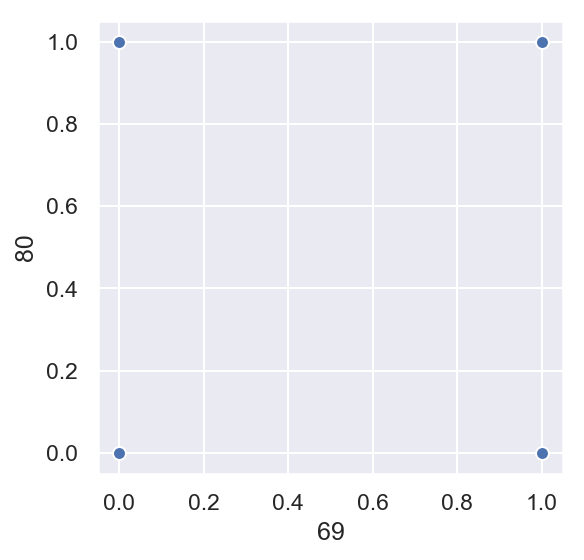

In [9]:
sns.scatterplot(69, 80, data=vote_pivot);

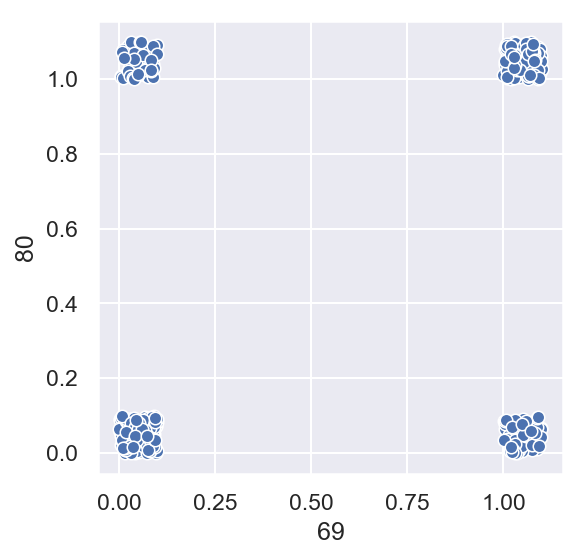

In [10]:
sns.scatterplot(69, 80, data=vote_pivot + np.random.random(vote_pivot.shape) * 0.1);

## PCA

In [11]:
D = vote_pivot.values
n = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

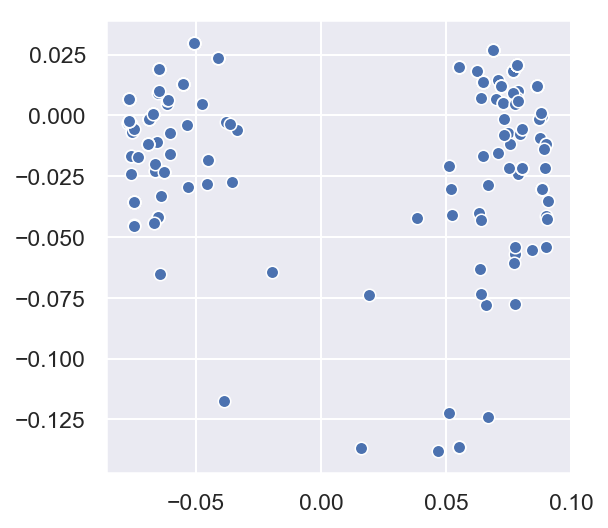

In [12]:
t = X @ vt.T
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

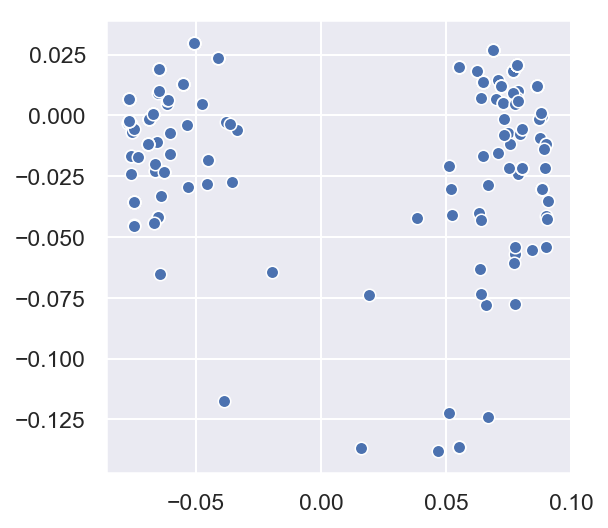

In [13]:
t = u * s
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

In [14]:
vote2d = pd.DataFrame({
    'member': vote_pivot.index,
    'pc1': t[:, 0],
    'pc2': t[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

vote2d[vote2d['pc1'] < 0]['party'].value_counts()

Democrat    231
Name: party, dtype: int64

In [15]:
vote2d[vote2d['pc1'] > 0]['party'].value_counts()

Republican    198
Democrat        7
Name: party, dtype: int64

In [16]:
vote2d[vote2d['pc2'] < -0.1]

,member,pc1,pc2,leg_id,first,last,gender,state,chamber,party,birthday
8,A000376,0.051189,-0.122572,A000376,Colin,Allred,M,TX,rep,Democrat,1983-04-15
107,D000624,0.016246,-0.137002,D000624,Debbie,Dingell,F,MI,rep,Democrat,1953-11-23
151,G000582,0.066830,-0.124139,G000582,Jenniffer,González-Colón,F,PR,rep,Republican,1976-08-05
284,N000147,0.055071,-0.136484,N000147,Eleanor,Norton,F,DC,rep,Democrat,1937-06-13
297,P000197,0.046890,-0.137972,P000197,Nancy,Pelosi,F,CA,rep,Democrat,1940-03-26
309,P000610,0.055071,-0.136484,P000610,Stacey,Plaskett,F,VI,rep,Democrat,1966-05-13
358,S001177,0.055071,-0.136484,S001177,Gregorio,Sablan,M,MP,rep,Democrat,1955-01-19
416,W000808,-0.038850,-0.117439,W000808,Frederica,Wilson,F,FL,rep,Democrat,1942-11-05


In [17]:
vote_pivot.loc['P000197']

roll call
66    0
67    0
68    0
69    0
70    0
71    0
72    0
73    0
74    0
75    0
76    0
77    0
78    0
79    0
80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    1
Name: P000197, dtype: int64

In [18]:
df = votes[votes['member'].isin(vote2d[vote2d['pc2'] < -0.1]['member'])]
df.groupby(['member', 'vote']).size()

member   vote      
A000376  Not Voting    20
         Yes            2
D000624  Not Voting    19
         Yes            3
G000582  No             1
         Yes            2
N000147  No             2
         Yes            1
P000197  Speaker       21
         Yes            1
P000610  No             2
         Yes            1
S001177  No             2
         Yes            1
W000808  No             1
         Not Voting    13
         Yes            8
dtype: int64

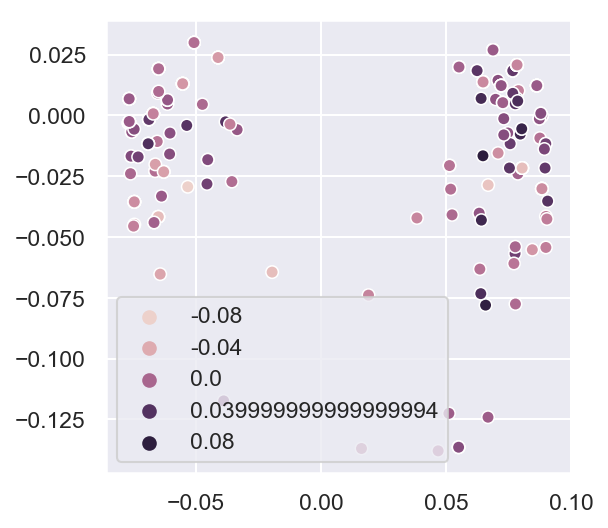

In [19]:
sns.scatterplot(x=t[:, 0], y=t[:, 1], hue=t[:, 2]);

In [20]:
yes_no_count = yes_no.groupby('member').size()
regulars = vote_pivot[yes_no_count > 12]
regulars.head()

roll call,66,67,68,69,70,71,72,73,74,75,...,78,79,80,81,82,83,84,85,86,87
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,1,0,0,1,1,1,1,1,1,...,0,0,0,1,1,0,1,0,0,0
A000369,1,1,0,0,1,1,1,1,1,1,...,0,0,0,1,1,0,1,0,0,1
A000370,1,1,1,1,1,1,0,1,0,1,...,1,1,1,0,1,1,1,1,1,1
A000371,1,1,1,1,1,1,0,1,0,1,...,1,1,0,0,1,1,1,1,1,1
A000375,1,1,0,0,1,1,1,1,1,1,...,0,0,1,1,1,0,1,0,0,0


In [21]:
regulars.merge(legs, left_index=True, right_on='leg_id')['party'].value_counts()

Democrat      229
Republican    139
Name: party, dtype: int64

In [22]:
D = regulars.values
n = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

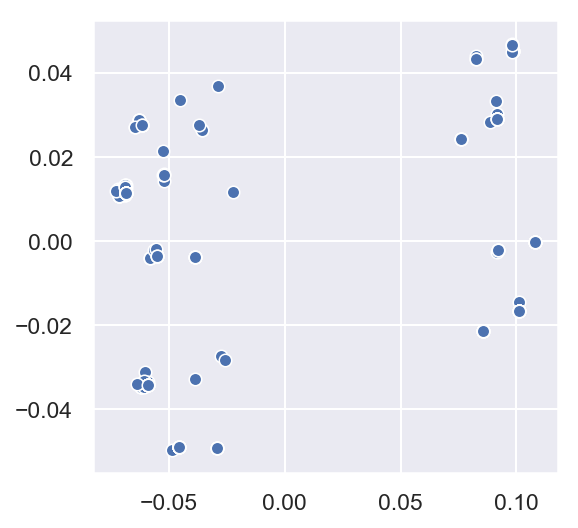

In [23]:
t = u * s
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

In [24]:
vote2d = pd.DataFrame({
    'member': regulars.index,
    'pc1': t[:, 0],
    'pc2': t[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

display(vote2d[vote2d['pc1'] < 0]['party'].value_counts())
display(vote2d[vote2d['pc1'] > 0]['party'].value_counts())

Democrat    229
Name: party, dtype: int64

Republican    139
Name: party, dtype: int64

## Variance

In [25]:
np.round(s**2, 2)

array([2.26, 0.19, 0.15, 0.11, 0.1 , 0.05, 0.05, 0.03, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [26]:
sum(s ** 2)

3.0690941044423456

In [27]:
np.var(D, axis=0)

array([0.01603852, 0.01603852, 0.23758713, 0.23876861, 0.01603852,
       0.02126654, 0.22600868, 0.04652056, 0.24146385, 0.02899781,
       0.05380878, 0.05859375, 0.23697424, 0.23634659, 0.24538487,
       0.24893667, 0.        , 0.22925774, 0.01865991, 0.23697424,
       0.23634659, 0.17908199])

In [28]:
sum(np.var(D, axis=0))

3.0690941044423448

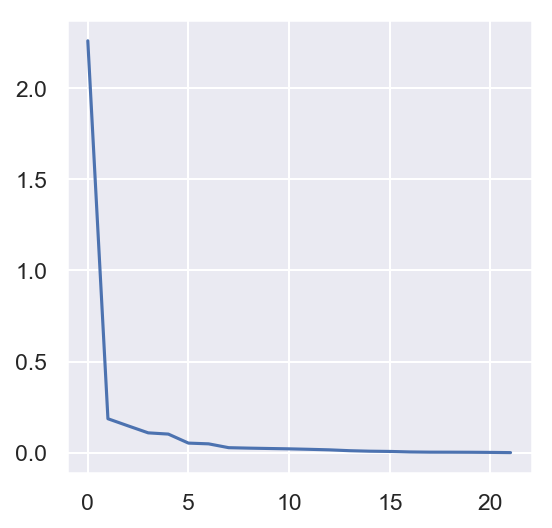

In [29]:
# scree plot
plt.plot(s**2);

In [30]:
np.round(s**2 / sum(s** 2), 2)

array([0.74, 0.06, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [31]:
np.round(np.cumsum(s**2) / sum(s** 2), 2)

array([0.74, 0.8 , 0.85, 0.88, 0.91, 0.93, 0.95, 0.96, 0.96, 0.97, 0.98,
       0.98, 0.99, 0.99, 0.99, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [32]:
# Variance from top two votes
sum(sorted(np.var(D, axis=0))[-2:]) / sum(np.var(D, axis=0))

0.16106431456900258

## Interpretation

In [33]:
vt[0, :]

array([ 0.0017577 ,  0.0017737 , -0.31671427, -0.31446187,  0.00212895,
        0.00138064,  0.29692541,  0.0255229 ,  0.31098011,  0.00816289,
        0.02843402,  0.03147932, -0.31731409, -0.31851361, -0.18548161,
        0.2573054 ,  0.        , -0.30341779,  0.00704033, -0.3166706 ,
       -0.31788216, -0.13119605])

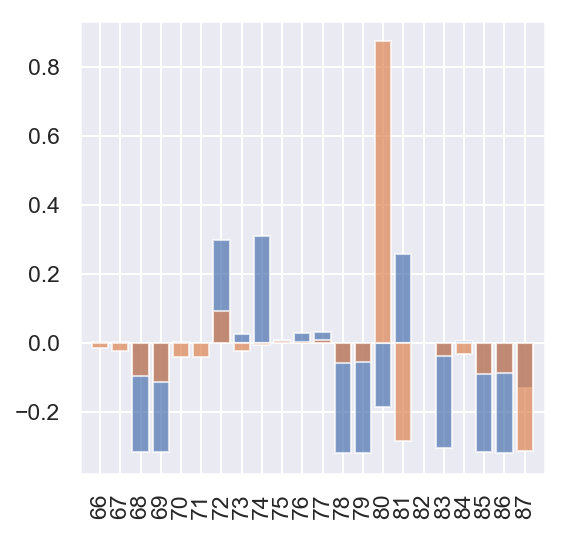

In [36]:
num_votes = vt.shape[1]
votes = regulars.columns

def plot_pc(k):
    plt.bar(votes, vt[k, :], alpha=0.7)
    plt.xlim((min(votes)-1, max(votes)+1))
    plt.xticks(votes, rotation=90);

plot_pc(0)
plot_pc(1)

## Analyzing Votes

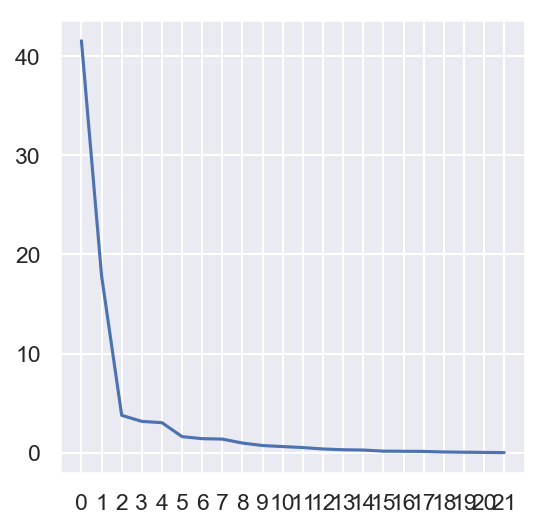

In [37]:
D = vote_pivot.values.T
n = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(n)
u, s, vt = np.linalg.svd(X, full_matrices=False)
plt.plot(s**2);
plt.xticks(np.arange(len(s)));

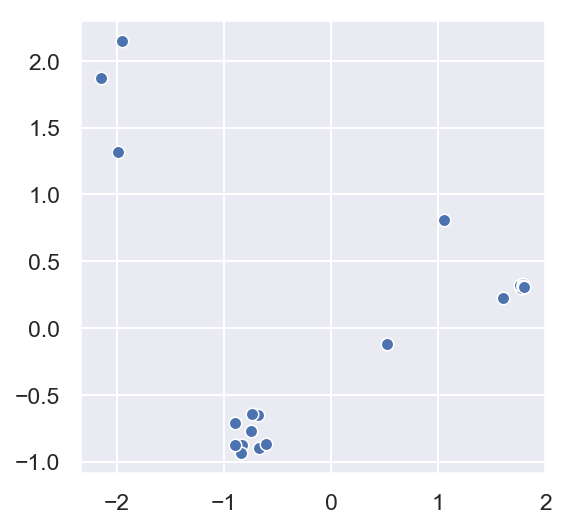

In [38]:
t = u * s
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

In [39]:
sorted(zip(t[:, 0], votes))

[(-2.146842745039069, 74),
 (-1.993171730427548, 81),
 (-1.9543713055743208, 72),
 (-0.9021553717697707, 73),
 (-0.9000148185499677, 84),
 (-0.8456804161643557, 70),
 (-0.8438552364026883, 82),
 (-0.8313051938435616, 71),
 (-0.7511666791511921, 75),
 (-0.7371949340309049, 77),
 (-0.6835723536173276, 76),
 (-0.6709746212467903, 66),
 (-0.6100716768825314, 67),
 (0.5228428369588904, 87),
 (1.0485858097667433, 80),
 (1.5989037929221532, 83),
 (1.760378985635477, 69),
 (1.771123346677043, 68),
 (1.7870018616853767, 78),
 (1.7917136669407356, 79),
 (1.7921464285197946, 85),
 (1.7976803535938095, 86)]